# Data Modelisation

- Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from nlp_module import remove_stopwords, plot_top_words, tok, print_score
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
sklearn.set_config(display="diagram")

## 1) Data preparation

In [3]:
path = "datasets/posts_with_tags_more_frequent.csv"

In [4]:
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,"python, web-services"
1,415344,log implementation prefer,implement log class c try decide curious know ...,"debugging, language-agnostic, logging"
2,414981,directly modify list element,struct struct map public int size public map i...,"c#, .net"


Missing data will be inspected. Indeed, we haven't watched missing values for titles yet. 

In [5]:
data.isnull().mean()

Id       0.000000
Title    0.000000
Body     0.000007
Tags     0.000000
dtype: float64

Missing values for titles represent less than 1% of our dataset. We can delete them. 

In [6]:
data.dropna(inplace=True)

Our data is composed by title of the posts, body and associated tags. As we can see, our data needs a bit of preprocessing. In one hand, signs "<" and ">" will be remove and in other hand, texts inside body will be written in lower case and stopwords will be removed. 

In [7]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [8]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,"python, web-services"
1,415344,log implementation prefer,implement log class c try decide curious know ...,"debugging, language-agnostic, logging"
2,414981,directly modify list element,struct struct map public int size public map i...,"c#, .net"


Our dataset is ready for the next step. Before, data will be resampling. In order to accelerate the modeling's stages, only 10% of our data will be used.

In [9]:
data = data.sample(frac=0.05, random_state=42)

Moreover, we decide to consider title and body as a whole text. We aggregate these data in a new variable nammed "docs". 

In [10]:
docs = data["Title"].values + " " + data["Body"].values

Finally, we can vectorize our data. In order to realise a first classification with NMF, the chosen vectorizer is TF-IDF. The sparsicity of our vectorized data is evaluated. 

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [12]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.392 %


Sparsicity is less than 1%.

## 2) Topic Modelling

Topic Modelling is an unsupervised method. These methods are used in order to find a classification inside our text. 

### a) Non Negative Matrix Factorization (NMF)

In [13]:
best_num_topics = 10

In [14]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [15]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=10, random_state=42)

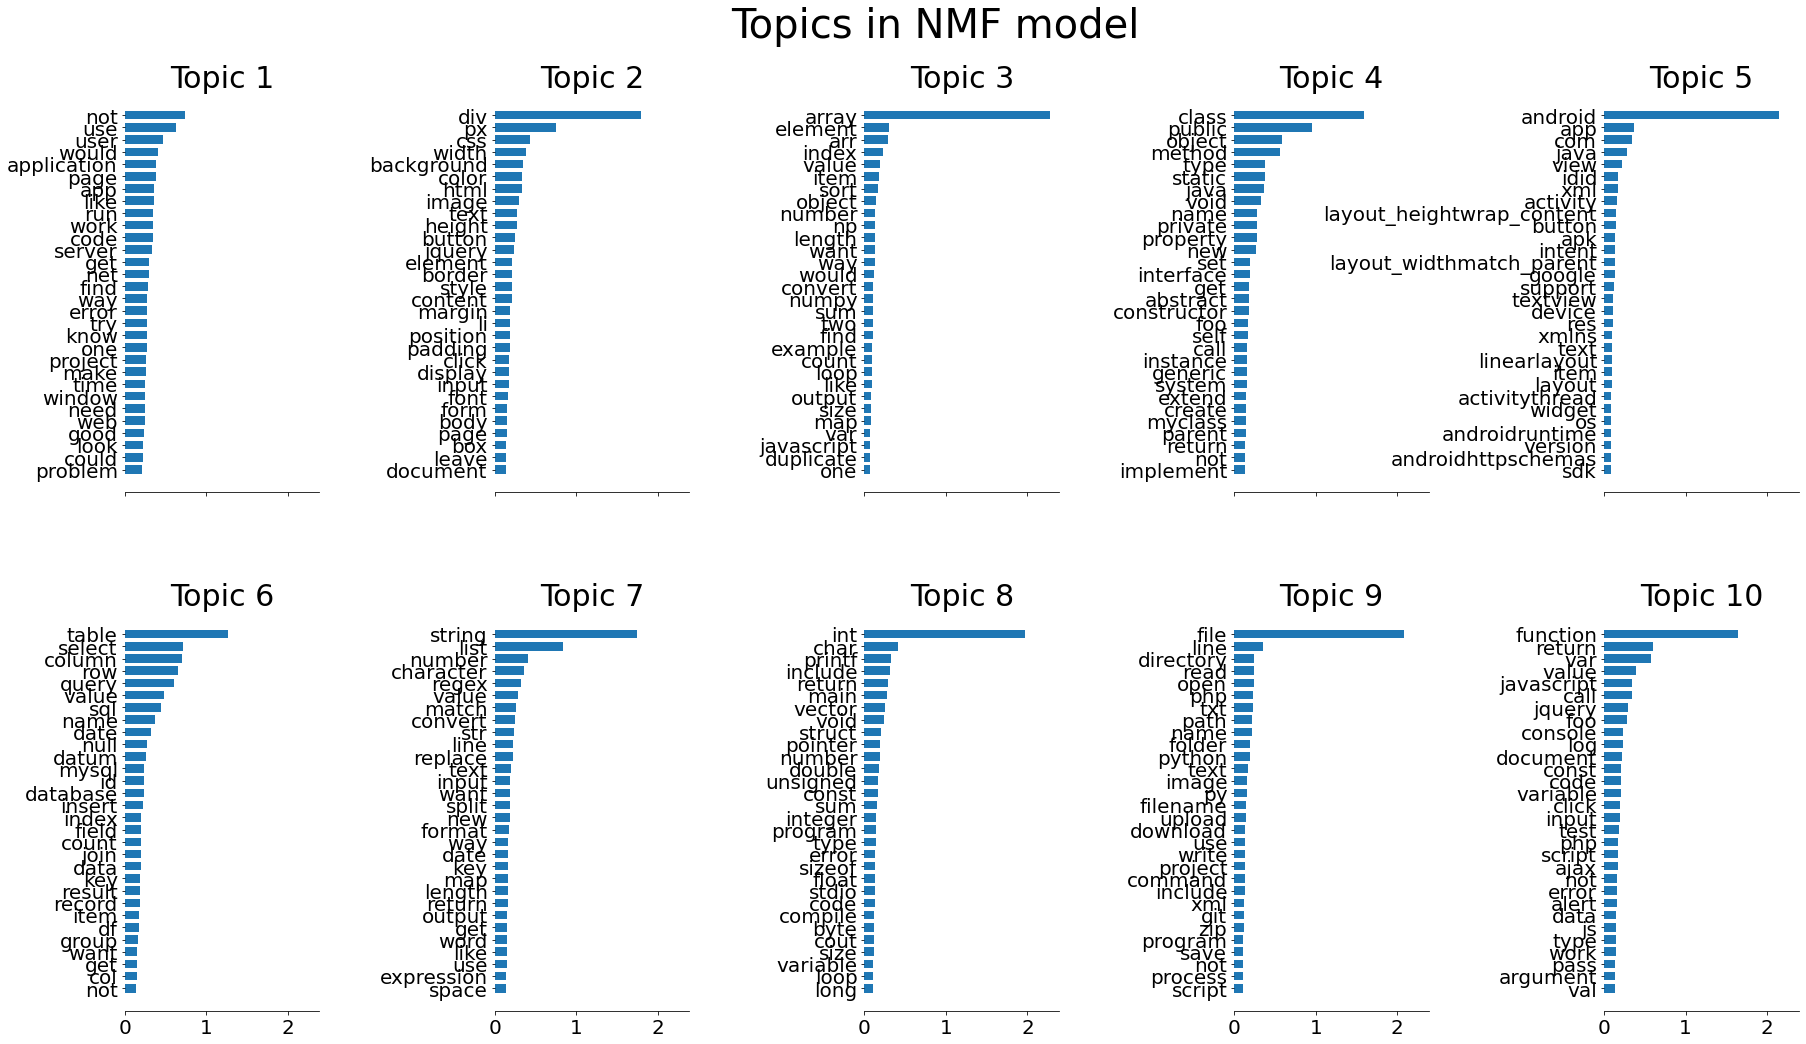

In [16]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

In [17]:
del nmf
gc.collect()

59105

### b) Latent Dirichlet Allocation (LDA)

In [18]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=tok)
docs_bow = bow_vectorizer.fit_transform(docs)

In [19]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)

In [20]:
params = {'n_components' : [8, 9, 10],
          "learning_decay" : [0.5, 0.7, 0.9],
          "learning_method" : ["batch", "online"]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,
                              verbose=2)
gridsearch_lda.fit(docs_bow)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  21.4s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  21.4s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  20.6s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  21.3s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  21.3s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  20.8s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  20.4s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  20.7s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  21.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  21.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=10; 

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [8, 9, 10]},
             verbose=2)

In [21]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}
Best Log Likelihood Score:  -1502794.9728198922


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -108.958252 -208.941483       1        1  67.947526
7      186.487061  -98.103249       2        1  11.288550
6       19.245832  160.858780       3        1   9.566197
4      170.658829   75.445076       4        1   3.248178
3       -1.386411  -35.043739       5        1   2.666953
0     -145.800095  106.944611       6        1   1.925750
5       64.834541 -221.825272       7        1   1.703480
2     -196.906036  -58.990913       8        1   1.653366, topic_info=          Term          Freq         Total Category  logprob  loglift
333          ]  12377.000000  12377.000000  Default  30.0000  30.0000
2            [   8475.000000   8475.000000  Default  29.0000  29.0000
2336   android   2693.000000   2693.000000  Default  28.0000  28.0000
24998     java   2544.000000   2544.000000  Default  27.0000  27.0000
13133      div   2093.000000   2093.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
51671     void     34.497997   1403.003247   Topic8  -5.9205   0.3969
6152      call     32.241584   1797.569878   Topic8  -5.9882   0.0814
6882      char     24.689910    801.489350   Topic8  -6.2550   0.6223
15785        f     22.073459   1050.710549   Topic8  -6.3670   0.2395
45615   studio     20.711580    267.381690   Topic8  -6.4307   1.5444

[554 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          2  0.991834         &#9
1          2  0.991823           ;
2          1  0.855863           [
2          2  0.060054           [
2          3  0.010029           [
...      ...       ...         ...
53284      5  0.008908       xmlns
53284      8  0.008908       xmlns
53361      3  0.281462         xsl
53361      8  0.716164         xsl
53767      3  0.982816  zygoteinit

[1510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 7, 5, 4, 1, 6, 3])

- Topic 1 : Top topic - Generalities
- Topic 2 : Web Language/Front-End
- Topic 3 : Programming Language/Portable Language (Java, Android)
- Topic 4 : Script Language (Python, Javascript)
- Topic 5 : OS (Windows, errors)
- Topic 6 : Web Language/Specific functions
- Topic 7 : Examples
- Topic 8 : Application utilities (geometry, physics)

In [23]:
del lda
gc.collect()

197

### c) Evaluation of topic modelling

In [24]:
warnings.filterwarnings("ignore")

from gensim.corpora.dictionary import Dictionary

dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [25]:
from gensim.models import Nmf

nmf = Nmf(corpus, num_topics=10, id2word=common_dictionary)

In [26]:
from gensim.models.ldamodel import LdaModel

lda = LdaModel(corpus, num_topics=8, id2word=common_dictionary)

In [27]:
from gensim.models.coherencemodel import CoherenceModel

cm_nmf = CoherenceModel(model=nmf, texts=dataset, corpus=corpus, coherence='c_v')
coherence_nmf = cm_nmf.get_coherence()
cm_lda = CoherenceModel(model=lda, texts=dataset, corpus=corpus, coherence='c_v')
coherence_lda = cm_lda.get_coherence()

In [28]:
print("Coherence Model - NMF: ", coherence_nmf.round(3))
print("Coherence Model - LDA: ", coherence_lda.round(3))

Coherence Model - NMF:  0.414
Coherence Model - LDA:  0.416


## 3) Supervised learning for text classification

### a) Data preparation

In [29]:
tags = data["Tags"].apply(lambda x: x[0:].split(','))

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_mlb = mlb.fit_transform(tags)

In [31]:
from sklearn.model_selection import train_test_split

X = docs
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [32]:
vectorizer = TfidfVectorizer(ngram_range =(1,1),
                            tokenizer=tok,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [33]:
X_test_vec = vectorizer.transform(X_test)

### b) Naive Bayes Classifier

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, 
                                           class_prior=None))
nb_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [35]:
y_pred_nb = nb_clf.predict(X_test_vec)

In [36]:
print_score(y_test, y_pred_nb)

Hamming loss (Misclassification Ratio): 0.0007048389651995846
Label-Based Accuracy: 0.0018497438816163915
Subset Accuracy:  0.0005691519635742744
F1-score Micro:  0.0029051670471052092


- Grid Search

In [37]:
from sklearn.metrics import make_scorer, f1_score

scorer_multilabel = make_scorer(f1_score,
                                average="micro")

In [38]:
from sklearn.model_selection import GridSearchCV

params = {"estimator__alpha": [0.3, 0.5, 0.7, 0.9, 1.0]}

gridsearch_nb = GridSearchCV(estimator=nb_clf, 
                             param_grid=params, 
                             scoring=scorer_multilabel,
                             cv=5,
                             verbose = 2)
gridsearch_nb.fit(X_train_vec, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............................estimator__alpha=0.3; total time=   6.6s
[CV] END ...............................estimator__alpha=0.3; total time=   6.4s
[CV] END ...............................estimator__alpha=0.3; total time=   6.9s
[CV] END ...............................estimator__alpha=0.3; total time=   6.7s
[CV] END ...............................estimator__alpha=0.3; total time=   6.4s
[CV] END ...............................estimator__alpha=0.5; total time=   6.4s
[CV] END ...............................estimator__alpha=0.5; total time=   6.4s
[CV] END ...............................estimator__alpha=0.5; total time=   6.4s
[CV] END ...............................estimator__alpha=0.5; total time=   6.4s
[CV] END ...............................estimator__alpha=0.5; total time=   6.4s
[CV] END ...............................estimator__alpha=0.7; total time=   6.4s
[CV] END ...............................estimator

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=MultinomialNB()),
             param_grid={'estimator__alpha': [0.3, 0.5, 0.7, 0.9, 1.0]},
             scoring=make_scorer(f1_score, average=micro), verbose=2)

In [39]:
gridsearch_nb.best_estimator_

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.3))

In [40]:
gridsearch_nb.best_params_

{'estimator__alpha': 0.3}

In [41]:
best_model_nb = gridsearch_nb.best_estimator_

In [42]:
del y_pred_nb
gc.collect()

192

- Model Evaluation

In [43]:
y_pred_nb = best_model_nb.predict(X_test_vec)

In [44]:
print_score(y_test, y_pred_nb)

Hamming loss (Misclassification Ratio): 0.0006957442688744287
Label-Based Accuracy: 0.018535382280402198
Subset Accuracy:  0.003414911781445646
F1-score Micro:  0.033421642551457104


### c) Support Vector Machine

In [45]:
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(random_state=42))
svm_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

In [46]:
y_pred_svm = svm_clf.predict(X_test_vec)

In [47]:
print_score(y_test, y_pred_svm)

Hamming loss (Misclassification Ratio): 0.0006331082151511773
Label-Based Accuracy: 0.1374312274710681
Subset Accuracy:  0.03813318155947638
F1-score Micro:  0.20778267254038174


In [48]:
del y_pred_svm
gc.collect()

24

## 4) Machine Learning for Multilabel Classification

### a) Algorithm Adaptation approaches

In [49]:
X_train_vec = X_train_vec.toarray()
y_train = np.array(y_train)

In [50]:
X_test_vec = X_test_vec.toarray()
y_test = np.array(y_test)

- Multilabel KNN

In [51]:
from skmultilearn.adapt import MLkNN

mlknn_clf = MLkNN()
mlknn_clf.fit(X_train_vec, y_train)

MLkNN()

In [52]:
y_pred = mlknn_clf.predict(X_test_vec)

In [53]:
y_pred = y_pred.tocsc()
y_pred = y_pred.toarray()

In [54]:
print_score(y_test, y_pred)

Hamming loss (Misclassification Ratio): 0.0006593654835738049
Label-Based Accuracy: 0.1619101823996531
Subset Accuracy:  0.028457598178713718
F1-score Micro:  0.2544368883728645


In [55]:
parameters = {'k': range(6,12), 
              's': [0.7, 1.0]}


gridsearch_mlknn = GridSearchCV(mlknn_clf, 
                   parameters, 
                   scoring=scorer_multilabel, 
                   verbose=2)
gridsearch_mlknn.fit(X_train_vec,
                     y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................................k=6, s=0.7; total time= 5.9min
[CV] END .........................................k=6, s=0.7; total time= 5.8min
[CV] END .........................................k=6, s=0.7; total time= 5.9min
[CV] END .........................................k=6, s=0.7; total time= 5.8min
[CV] END .........................................k=6, s=0.7; total time= 5.8min
[CV] END .........................................k=6, s=1.0; total time= 5.8min
[CV] END .........................................k=6, s=1.0; total time= 6.2min
[CV] END .........................................k=6, s=1.0; total time= 5.9min
[CV] END .........................................k=6, s=1.0; total time= 5.8min
[CV] END .........................................k=6, s=1.0; total time= 5.8min
[CV] END .........................................k=7, s=0.7; total time= 5.9min
[CV] END .......................................

GridSearchCV(estimator=MLkNN(), param_grid={'k': range(6, 12), 's': [0.7, 1.0]},
             scoring=make_scorer(f1_score, average=micro), verbose=2)

In [56]:
gridsearch_mlknn.best_params_

{'k': 11, 's': 0.7}

In [57]:
best_model_mlknn = gridsearch_mlknn.best_estimator_

In [58]:
del y_pred
gc.collect()

24

In [59]:
y_pred = best_model_mlknn.predict(X_test_vec)
y_pred = y_pred.tocsc()
y_pred = y_pred.toarray()
print_score(y_test, y_pred)

Hamming loss (Misclassification Ratio): 0.0006634727657851657
Label-Based Accuracy: 0.16297259939832506
Subset Accuracy:  0.027888446215139442
F1-score Micro:  0.25718508786336014


In [60]:
del data
del tags_mlb
del tags
del y_pred
gc.collect()

0

## 5) Deep Learning for text classification

### a) Data Preparation

In [61]:
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,"python, web-services"
1,415344,log implementation prefer,implement log class c try decide curious know ...,"debugging, language-agnostic, logging"
2,414981,directly modify list element,struct struct map public int size public map i...,"c#, .net"


In [62]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

In [63]:
data.dropna(inplace=True)

In [64]:
data = data.sample(frac=0.05, random_state=42)

In [65]:
docs = data["Title"].values + " " + data["Body"].values

In [66]:
tags = data["Tags"].apply(lambda x: x[0:].split(','))

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

tags_mlb = mlb.fit_transform(tags)

In [68]:
from sklearn.model_selection import train_test_split

X = docs
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [69]:
max_sequence_length = 300

In [70]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=12000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [71]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [72]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_test = np.array(y_test)

In [73]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, InputLayer, LSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [74]:
vocab_size = 12000
embedding_dim = 64
max_length = 300

### b) Words Embedding: Introducing GloVe

In [75]:
path_to_glove_file = 'datasets/glove.840B.300d.txt'

In [76]:
warnings.filterwarnings("ignore")

embeddings_index = {}
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 2195885 word vectors.


In [77]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_vector = embedding_matrix[i]
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 7040 words (4960 misses)


### c) Building Model

In [78]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(max_length, )))
    model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False))
    model.add(LSTM(embedding_dim, 
                   activation="tanh",
                   return_sequences=True))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1],
              activation='sigmoid'))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(0.001))
    return model

In [79]:
model = build_model()

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           768128    
                                                                 
 lstm (LSTM)                 (None, 300, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 3898)              74845498  
                                                                 
Total params: 75,646,650
Trainable params: 74,878,522
Non-trainable params: 768,128
_________________________________________________________________


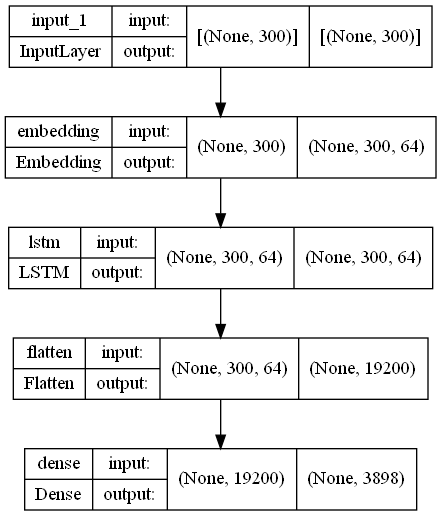

In [81]:
from tensorflow.keras.utils import plot_model
plot_model(model,
           to_file='illustrations/lstm.png',
           show_shapes=True,
           show_layer_names=True)

In [82]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2)

Epoch 1/5
75/75 - 26s - loss: 175.1329 - val_loss: 752.7637 - 26s/epoch - 345ms/step
Epoch 2/5
75/75 - 25s - loss: 1111.3274 - val_loss: 1517.1000 - 25s/epoch - 330ms/step
Epoch 3/5
75/75 - 25s - loss: 1438.9076 - val_loss: 1645.7869 - 25s/epoch - 331ms/step
Epoch 4/5
75/75 - 25s - loss: 1475.4232 - val_loss: 1770.2087 - 25s/epoch - 331ms/step
Epoch 5/5
75/75 - 25s - loss: 1478.1136 - val_loss: 1832.2993 - 25s/epoch - 331ms/step


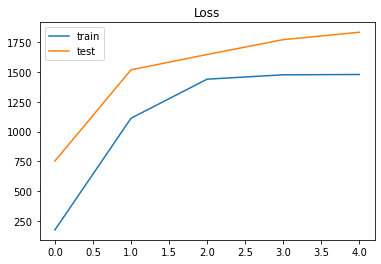

In [83]:
plt.title('Loss')
plt.plot(history.history['loss'],
         label='train')
plt.plot(history.history['val_loss'],
         label='test')
plt.legend()
plt.show()

In [84]:
y_pred = model.predict(X_test)

In [85]:
print_score(y_test, y_pred)

Hamming loss (Misclassification Ratio): 0.7865837828777246
Label-Based Accuracy: 0.0007486490055581811
Subset Accuracy:  0.0
F1-score Micro:  0.001496140284281482


### d) Tuning Hyperparameters

In [86]:
import keras_tuner as kt

In [87]:
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_length, )))
    model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False))
    model.add(LSTM(units = hp.Int(
                                'LSTM_1_units', 
                                min_value=32, 
                                max_value=512, 
                                step=32),
                   activation = "tanh"))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], 
                    activation = hp.Choice("activation_function",
                                           values=['sigmoid', "softmax"])))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  metrics = ['accuracy'])
    return model

In [88]:
warnings.filterwarnings("ignore")

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=False,
    seed = 42,
    directory="output",
    project_name="optimization_LSTM"
)

INFO:tensorflow:Reloading Oracle from existing project output\optimization_LSTM\oracle.json
INFO:tensorflow:Reloading Tuner from output\optimization_LSTM\tuner0.json


In [89]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
LSTM_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_function (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'softmax'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [90]:
tuner.search(X_train,
             y_train,
             epochs=2,
             validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [91]:
tuner.results_summary()

Results summary
Results in output\optimization_LSTM
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_1_units: 352
activation_function: sigmoid
learning_rate: 0.001
Score: 0.0444983821362257
Trial summary
Hyperparameters:
LSTM_1_units: 160
activation_function: sigmoid
learning_rate: 0.001
Score: 0.03964401315897703
Trial summary
Hyperparameters:
LSTM_1_units: 512
activation_function: softmax
learning_rate: 0.01
Score: 0.03317151963710785


In [92]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(max_length, )))
    model.add(Embedding(num_tokens,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False))
    model.add(LSTM(352,
                   activation="tanh",
                   return_sequences=True))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1],
              activation='sigmoid'))
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(0.001))
    return model

In [93]:
model = build_model()

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 64)           768128    
                                                                 
 lstm_1 (LSTM)               (None, 300, 352)          587136    
                                                                 
 flatten_1 (Flatten)         (None, 105600)            0         
                                                                 
 dense_1 (Dense)             (None, 3898)              411632698 
                                                                 
Total params: 412,987,962
Trainable params: 412,219,834
Non-trainable params: 768,128
_________________________________________________________________


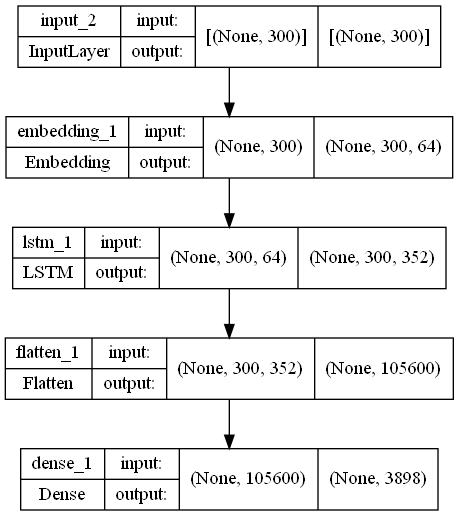

In [95]:
plot_model(model,
           to_file='illustrations/lstm_opti.png',
           show_shapes=True,
           show_layer_names=True)

In [96]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2)

Epoch 1/5
75/75 - 174s - loss: 2070.7180 - val_loss: 5410.8457 - 174s/epoch - 2s/step
Epoch 2/5
75/75 - 164s - loss: 6530.7158 - val_loss: 7544.4688 - 164s/epoch - 2s/step
Epoch 3/5
75/75 - 162s - loss: 7827.0864 - val_loss: 9246.7705 - 162s/epoch - 2s/step
Epoch 4/5
75/75 - 160s - loss: 8612.2119 - val_loss: 10012.5654 - 160s/epoch - 2s/step
Epoch 5/5
75/75 - 159s - loss: 8876.5225 - val_loss: 10752.5830 - 159s/epoch - 2s/step


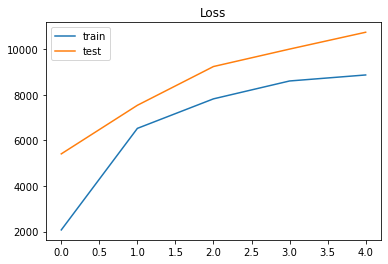

In [97]:
plt.title('Loss')
plt.plot(history.history['loss'],
         label='train')
plt.plot(history.history['val_loss'],
         label='test')
plt.legend()
plt.show()

In [98]:
y_pred = model.predict(X_test)
print_score(y_test, y_pred)

Hamming loss (Misclassification Ratio): 0.7865837828777246
Label-Based Accuracy: 0.0007486490055581811
Subset Accuracy:  0.0
F1-score Micro:  0.001496140284281482


**References**

- https://colah.github.io/posts/2015-08-Understanding-LSTMs/